In [1]:
import os
import numpy as np
from numpy import newaxis
import pickle
from PIL import Image
from matplotlib.pyplot import imshow
import time
import torch
from torchvision import transforms, datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from random import shuffle
import cv2
import time

In [2]:
parser = argparse.ArgumentParser(description='PyTorch Example')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--interval',metavar='N',default=100)



args = parser.parse_args(args=[])
args.cuda = not args.disable_cuda and torch.cuda.is_available()

In [3]:
def negativeThreshold(image):
    lpcount = 0.0
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r][c] > 127:
                lpcount+=1
                
    return lpcount/(256.*256.)

In [4]:
def transform_image(ip_img):
    
    #Rotate 90 Degrees Clockwise
    tr_img = cv2.transpose(ip_img)
    rotate_img_1 = cv2.flip(tr_img, +1)
    
    #Flip image vertically 
    rotate_img_2 = cv2.flip(tr_img, 0)
    
    #Rotate 180 degree flip
    rotate_img_3 = cv2.flip(tr_img, -1)
    
    
    
    return [tr_img,rotate_img_1,rotate_img_2,rotate_img_3]

In [241]:
training_path ='data/train/'
data_folder = [d for d in os.listdir(training_path) ]
all_mask_files = []
all_data=[]
size=(128,128)
lpthreshold = 0.15
for i in range(len(data_folder)):
    
#     flip = np.random.randint(3)
    
    img_data_folder = [k for k in os.listdir(training_path+data_folder[i])]
    img_files =[k for k in os.listdir(training_path+data_folder[i]+'/'+img_data_folder[1])]
    masks_files = [k for k in os.listdir(training_path+data_folder[i]+'/'+img_data_folder[0])]
    current_mask_files=[]
    for j in range(len(masks_files)):
        
        mask_img = cv2.imread(training_path+data_folder[i]+'/'+img_data_folder[0]+'/'+masks_files[j])
        mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
        mask_img = cv2.resize(mask_img, size,interpolation = cv2.INTER_AREA) 
        
        mask_img = np.asarray(mask_img)
        
        mask_img = mask_img /255.0
        

        current_mask_files.append(mask_img)
        
    current_mask_files = np.array(current_mask_files)
    temp= np.max(current_mask_files,axis=0)
    
    
    all_mask_files.append(temp)
    
    for j in range(len(img_files)):
        
        ip_img = cv2.imread(training_path+data_folder[i]+'/'+img_data_folder[1]+'/'+img_files[j])
        ip_img = cv2.cvtColor(ip_img, cv2.COLOR_BGR2GRAY)
        ip_img = cv2.resize(ip_img, size,interpolation = cv2.INTER_AREA)
        all_data.append(ip_img/255.)
        if negativeThreshold(ip_img) > lpthreshold:
            ip_img = 255 - ip_img
            augmented_img_ls = transform_image(ip_img)
            augmneted_mask_img_ls = transform_image(all_mask_files[-1])    
            for ele in augmented_img_ls:
                all_data.append(ele/255.0)
            for ele in augmneted_mask_img_ls:
                all_mask_files.append(ele)
        

In [243]:
data_dict ={"all_data":all_data,"all_mask_files":all_mask_files}
with open('all_images_augmented.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
data_dict = pickle.load(open( "all_images_augmented.pickle", "rb" ) )

In [6]:
all_data,all_mask_files = data_dict["all_data"],data_dict["all_mask_files"]

In [7]:
import random
val_data_size = 130
val_data_sampler =random.sample(range(len(all_data)), val_data_size)

shuffle(val_data_sampler)
print(val_data_sampler)
print(len(val_data_sampler))

[73, 587, 502, 177, 126, 322, 16, 782, 738, 806, 562, 392, 277, 574, 1075, 440, 410, 1022, 929, 902, 21, 379, 273, 79, 739, 592, 1038, 85, 804, 104, 514, 845, 254, 1043, 559, 1001, 817, 513, 839, 398, 141, 18, 597, 413, 1080, 759, 318, 408, 647, 451, 734, 497, 808, 387, 510, 770, 152, 1059, 332, 1120, 265, 59, 115, 1091, 416, 1021, 1026, 238, 156, 735, 266, 417, 964, 282, 823, 307, 828, 549, 1083, 241, 338, 602, 746, 526, 65, 820, 299, 547, 963, 989, 1111, 153, 330, 1081, 927, 801, 586, 951, 380, 132, 564, 516, 71, 441, 885, 617, 636, 517, 361, 1020, 892, 640, 1045, 1122, 347, 696, 406, 114, 730, 1028, 1109, 335, 728, 758, 424, 137, 29, 462, 376, 673]
130


In [8]:
val_img,val_mask,training_img,training_mask=[],[],[],[]
print(len(all_data))
for i in range(len(all_data)):
    if i in val_data_sampler:
        val_img.append(all_data[i])
        val_mask.append(all_mask_files[i])
    else:
        training_img.append(all_data[i])
        training_mask.append(all_mask_files[i])

1130


In [9]:
print(len(training_img))
print(len(training_mask))
print(len(val_img))
print(len(val_mask)) 

1000
1000
130
130


In [21]:
#Segmentation Network
class SegUnet(nn.Module):
    """SegUnet network."""

    def __init__(self, input_nbr, label_nbr):
        """Init fields."""
        super(SegUnet, self).__init__()

        self.input_nbr = input_nbr

        batchNorm_momentum = 0.99
        
        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        
        #between encoder and decoder
        self.conv51ed = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51ed = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52ed = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52ed = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv53ed = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53ed = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        
        
        
        self.conv53d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv43d = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv33d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv22d = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)

    def forward(self, x):
        
        """Forward method."""
        # Stage 1
#         print(x.shape)
        x11 = F.relu(self.bn11(self.conv11(x)))
        
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12, kernel_size=2, stride=2, return_indices=True)
        size1 = x12.size()

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22, kernel_size=2, stride=2, return_indices=True)
        size2 = x22.size()
        
        
        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33, kernel_size=2, stride=2, return_indices=True)
        size3 = x33.size()

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43, kernel_size=2, stride=2, return_indices=True)
        size4 = x43.size()

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53, kernel_size=2, stride=2, return_indices=True)
        size5 = x53.size()
        
        
        
        #Between Encoder and Decoder
        x51ed = F.relu(self.bn51ed(self.conv51ed(x5p)))
        x52ed = F.relu(self.bn52ed(self.conv52ed(x51ed)))
        x53ed = F.relu(self.bn53ed(self.conv53ed(x52ed)))
 
        
        
        
        
        
        
        # Stage 5d
        x5d = F.max_unpool2d(x53ed, id5, kernel_size=2, stride=2, output_size=size5)
        

        concat_5 = torch.cat([x53,x5d],dim=1)
        
        x53d = F.relu(self.bn53d(self.conv53d(concat_5)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))
        
        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2, output_size=size4)
        
        concat_4 = torch.cat([x4d,x43],dim=1)
       
        
        x43d = F.relu(self.bn43d(self.conv43d(concat_4)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2, output_size=size3)
        concat_3 = torch.cat([x3d,x33],dim=1)
        
        x33d = F.relu(self.bn33d(self.conv33d(concat_3)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2, output_size=size2)
        concat_4 = torch.cat([x2d,x22],dim=1)
        
        x22d = F.relu(self.bn22d(self.conv22d(concat_4)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2, output_size=size1)
        concat_4 = torch.cat([x1d,x12],dim=1)
        
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = F.sigmoid(self.conv11d(x12d))
        
        return x11d

In [22]:
seg_unet = SegUnet(1,1)
if torch.cuda.is_available():
    seg_unet = seg_unet.cuda()

In [23]:
loss_fn = torch.nn.BCELoss()

In [24]:
optimizer = torch.optim.Adam(seg_unet.parameters(), betas=(0.9,0.99),lr=1e-4, weight_decay= 0.00025)

In [25]:
epochs=100
train_loss=[]
threshold = 0.5
mini_batch=2
val_acc =[]

In [26]:
val_img_torch = [ torch.from_numpy(np.array(image, dtype=np.float32)) 
                   for key , image in enumerate(val_img)]
val_mask_torch = [ torch.from_numpy(np.array(mask, dtype=np.float32))
                   for key , mask in enumerate(val_mask)]

val_f_images = list(torch.stack(val_img_torch,0).view(len(val_img_torch),1,val_img_torch[0].shape[0],val_img_torch[0].shape[1]))
val_f_masks = list(torch.stack(val_mask_torch,0).view(len(val_mask_torch),1,val_mask_torch[0].shape[0],val_mask_torch[0].shape[1]))

In [27]:
def jaccard_coeff( A, B, no_positives=1.0):
       
        # Make sure the shapes are the same.
        A = A.squeeze()
        B = B.squeeze()
        
        if not A.shape == B.shape:
            raise ValueError("A and B must be the same shape")

        # Make sure values are between 0 and 1.
        if np.any( (A>1.) | (A<0) | (B>1.) | (B<0)):
            raise ValueError("A and B must be between 0 and 1")

        # Flatten to handle nd arrays.
        A = A.flatten()
        B = B.flatten()
        

        intersect = np.minimum(A,B)
        union = np.maximum(A, B)

        # Special case if neither A or B have a 1 value.
        if union.sum() == 0:
            return no_positives

        # Compute the Jaccard.
        J = intersect.sum() / union.sum()
        return J

In [28]:
def getDataBatch(samples,img_dataset,mask_dataset):
     
    images = []
    masks = []
    
    for idx in samples:
        
        #print('------------',idx)
        image = img_dataset[idx]
        mask = mask_dataset[idx]

        flip = np.random.randint(3)
        
        # Horizontal Flip
        if flip == 1:
            
            image = torch.from_numpy(cv2.flip(image,0))
            mask = torch.from_numpy(cv2.flip(mask,0))
            
        # Vertical Flip    
        if flip == 2:
            
            image = torch.from_numpy(cv2.flip(image,1))
            mask = torch.from_numpy(cv2.flip(mask,1))
            
        # Vertical + Horizontal Flip    
        if flip == 0:
            
            image = torch.from_numpy(cv2.flip(image,-1))
            mask = torch.from_numpy(cv2.flip(mask,-1))
        
        images.append(image)
        masks.append(mask)
            
    return torch.stack(images),torch.stack(masks)

In [29]:
def train_eval_model():
#   Training the model
    best_j_coeff = -100.00
    sampler = [ i for i in range(0,len(training_img))]
    for epoch in range(epochs):
        seg_unet.train()
        total_loss_val = 0.0
        shuffle(sampler)
        
        batch_sampler = np.array_split(sampler,len(sampler)//mini_batch)
        print("----------------------------- Epoch : {} ---------------------------------".format(epoch))
        for idx,sample in enumerate(batch_sampler):
            
            images,tgtmask = getDataBatch(sample,training_img,training_mask)
            

            
            image=images.type(torch.FloatTensor)
            mask = tgtmask.type(torch.FloatTensor)

            
            
            if args.cuda:
                image = Variable(image.view(image.shape[0],1,image.shape[1],image.shape[2]).cuda())
                mask = Variable(mask.view(mask.shape[0],1,mask.shape[1],mask.shape[2]).cuda())
            else:
                image = Variable(image.view(image.shape[0],1,image.shape[1],image.shape[2]))
                mask = Variable(mask.view(mask.shape[0],1,mask.shape[1],mask.shape[2]))

            # image,mask = Variable(image),Variable(mask)
            # Clears the gradients of all optimized Variables


            optimizer.zero_grad()
            y_pred = seg_unet(image)


            loss = loss_fn(y_pred, mask)
            total_loss_val +=loss.data[0]
            loss.backward()

            optimizer.step()

#             if batch_idx and not batch_idx % args.interval:
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch, batch_idx * len(image), len(training_img),
#             100. * batch_idx / len(training_img), loss.data[0]))
            
        train_loss.append(total_loss_val / len(sampler))
        print()
        print ('Total training loss of Epoch {} : {:.4f}'.format(epoch,total_loss_val / len(sampler)))
        
#     Evaluate Model and save the best model in best_model folder
    
        seg_unet.eval()
        
        j_coeff =0.0
        
        for idx, image in enumerate(val_f_images):

            image = image.type(torch.FloatTensor)

            if args.cuda:
                image = Variable(image.view(1,1,image.shape[1],image.shape[2]).cuda())
            else:
                image = Variable(image.view(1,1,image.shape[1],image.shape[2]))

            vout = seg_unet(image)

            vout.ge_(threshold).float()

            j_coeff += jaccard_coeff(vout.cpu().data[0].numpy(),val_f_masks[idx].numpy())

        avg_j_coeff = j_coeff/len(val_f_images)
        val_acc.append(avg_j_coeff)
        print()
        print('The mean IoU of validation data is : %.8f '%avg_j_coeff)
        if avg_j_coeff >= best_j_coeff:
            
            state = {'epoch': epoch+1,
                     'total_training_loss':train_loss,
                         'model_state': seg_unet.state_dict(),
                         'validation_accuracy':val_acc,
                         'optimizer_state' : optimizer.state_dict(),}
            torch.save(state, "segunet_best_model_adam_augmented_200_0.0001/segunet_best_model.pkl")
            best_j_coeff = avg_j_coeff
        print("------------------------------------------------------------------------")
        
        if (epoch+1) == epochs:
            state = {'epoch': epoch+1,
                     'total_training_loss':train_loss,
                         'model_state': seg_unet.state_dict(),
                         'validation_accuracy':val_acc,
                         'optimizer_state' : optimizer.state_dict(),}
            torch.save(state, "segunet_best_model_adam_augmented_200_0.0001/segunet_best_model_final.pkl")
           

In [30]:
start_time = time.time()
train_eval_model()
print("--- The total training time of segnet model is %s seconds ---" % (time.time() - start_time))

----------------------------- Epoch : 0 ---------------------------------

Total training loss of Epoch 0 : 0.1410

The mean IoU of validation data is : 0.57468563 
------------------------------------------------------------------------
----------------------------- Epoch : 1 ---------------------------------

Total training loss of Epoch 1 : 0.0813

The mean IoU of validation data is : 0.45527319 
------------------------------------------------------------------------
----------------------------- Epoch : 2 ---------------------------------

Total training loss of Epoch 2 : 0.0737

The mean IoU of validation data is : 0.52108361 
------------------------------------------------------------------------
----------------------------- Epoch : 3 ---------------------------------

Total training loss of Epoch 3 : 0.0700

The mean IoU of validation data is : 0.38460385 
------------------------------------------------------------------------
----------------------------- Epoch : 4 --------


Total training loss of Epoch 34 : 0.0440

The mean IoU of validation data is : 0.42146564 
------------------------------------------------------------------------
----------------------------- Epoch : 35 ---------------------------------

Total training loss of Epoch 35 : 0.0430

The mean IoU of validation data is : 0.43487559 
------------------------------------------------------------------------
----------------------------- Epoch : 36 ---------------------------------

Total training loss of Epoch 36 : 0.0420

The mean IoU of validation data is : 0.69827061 
------------------------------------------------------------------------
----------------------------- Epoch : 37 ---------------------------------

Total training loss of Epoch 37 : 0.0430

The mean IoU of validation data is : 0.54338906 
------------------------------------------------------------------------
----------------------------- Epoch : 38 ---------------------------------

Total training loss of Epoch 38 : 0.043


The mean IoU of validation data is : 0.66479682 
------------------------------------------------------------------------
----------------------------- Epoch : 69 ---------------------------------

Total training loss of Epoch 69 : 0.0375

The mean IoU of validation data is : 0.61704965 
------------------------------------------------------------------------
----------------------------- Epoch : 70 ---------------------------------

Total training loss of Epoch 70 : 0.0379

The mean IoU of validation data is : 0.61462188 
------------------------------------------------------------------------
----------------------------- Epoch : 71 ---------------------------------

Total training loss of Epoch 71 : 0.0377

The mean IoU of validation data is : 0.69386499 
------------------------------------------------------------------------
----------------------------- Epoch : 72 ---------------------------------

Total training loss of Epoch 72 : 0.0374

The mean IoU of validation data is : 0.

In [31]:
testing_path ='data/test/'
data_folder = [d for d in os.listdir(testing_path) ]
lpthreshold = 0.15
test_data=[]
size=(128,128)
for i in range(len(data_folder)):
    
    img_data_folder = [k for k in os.listdir(testing_path+data_folder[i])]
    img_files =[k for k in os.listdir(testing_path+data_folder[i]+'/'+img_data_folder[0])]
    
    
    
    for j in range(len(img_files)):
        
        ip_img = Image.open(testing_path+data_folder[i]+'/'+img_data_folder[0]+'/'+img_files[j])
        ip_img = ip_img.resize(size,Image.BILINEAR)
        ip_img = ip_img.convert('L')
        ip_img = np.asarray(ip_img)
        
        
        
        test_data.append(ip_img)
        

In [32]:
model_state_dict = torch.load('segunet_best_model_adam_augmented_200_0.0001/segunet_best_model.pkl')
best_epoch = model_state_dict["epoch"]
training_loss = model_state_dict["total_training_loss"]
val_aucc = model_state_dict["validation_accuracy"]
seg_unet.load_state_dict(model_state_dict["model_state"])
print(best_epoch)
optimizer.load_state_dict(model_state_dict["optimizer_state"])

89


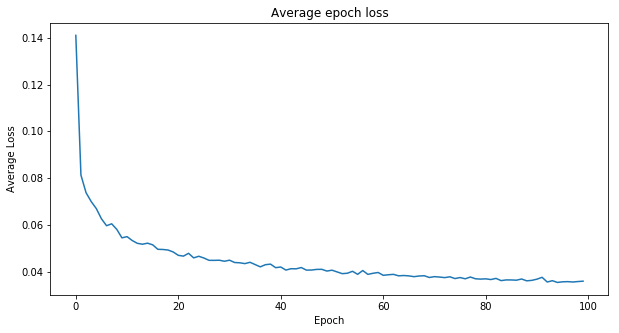

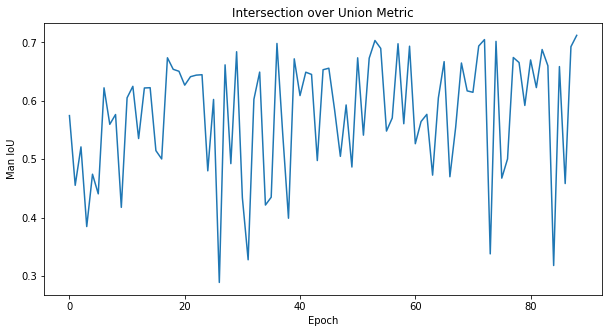

In [33]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 5)
# plt.plot(val_aucc)
plt.title("Average epoch loss")
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()
plt.title("Intersection over Union Metric")
plt.plot(val_aucc)
plt.xlabel("Epoch")
plt.ylabel("Man IoU")
plt.show()

In [34]:
def predict(images,masks,batch=20):
    seg_unet.eval()
    
 
    mean_precision = 0
    for threshold in [.5]:
        j_coeff = 0.0
        for idx, image in enumerate(val_f_images):
#             print(idx)
            image = image.type(torch.FloatTensor)
#             print(image.view(1,1,image.shape[1],image.shape[2]))
            if args.cuda:
                image = Variable(image.view(batch,1,image.shape[1],image.shape[2]).cuda())
            else:
                image = Variable(image.view(batch,1,image.shape[1],image.shape[2]))

            #print('Validation Image Shape:',validation_image.shape)

            vout = seg_unet(image)
            
            vout.ge_(threshold).float()
            
        
            j_coeff += jaccard_coeff(vout.cpu().data[0].numpy(),val_f_masks[idx].numpy())

            
        print('Average J-Coeff at %.2f : %.4f' % ( threshold ,j_coeff/len(val_f_images)))

In [35]:
predict(val_img_torch,val_mask_torch,batch=1)

Average J-Coeff at 0.50 : 0.7122


	Input image 	    Ground Truth Mask


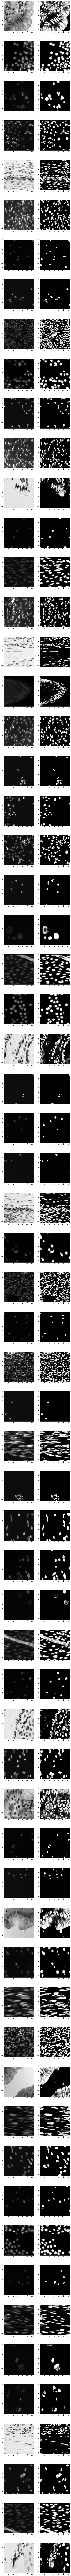

In [36]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 400)
plt_idx=0
print("\tInput image \t    Ground Truth Mask")
image_indexes=[0,30,10,20,3,5,8,14]
lpthreshold = 0.15
seg_unet.eval()
for idx,image in enumerate(test_data):
    
    plt.subplot(len(test_data),2,(idx*2)+1)
    image = test_data[idx]/255.
    
    image = np.asarray(image*255.,dtype='int32')
    plt.imshow(Image.fromarray(image))
    
    
    
    plt.subplot(len(test_data),2,(idx*2)+2)
    
    ip_img = test_data[idx]
    if negativeThreshold(ip_img) > lpthreshold:
        ip_img = 255 - ip_img
    ip_image = torch.from_numpy(ip_img/255.)
    ip_image = ip_image.type(torch.FloatTensor)
    
    if args.cuda:
        ip_image = Variable(ip_image.view(1,1,ip_image.shape[0],ip_image.shape[1]).cuda())
    else:
        ip_image = Variable(ip_image.view(1,1,ip_image.shape[0],ip_image.shape[1]))
    
    predicted_mask = seg_unet(ip_image).data[0][0].cpu().numpy()
    predicted_mask = np.asarray(predicted_mask*255.,dtype='int32')
    plt.imshow(Image.fromarray(predicted_mask))
    plt_idx +=2